this is a script to plot out stago hits from BLAST against nt database using the stago reads from the rgBLAST. using the ntBLAST output file.

In [33]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import argparse
import subprocess as sub
from ete3 import NCBITaxa 
ncbi = NCBITaxa()

In [34]:
BASEDIR = '/home/yiheng/analysis/WGS/total_stago.fasta.ntblastoutput'
df_headers = ['qseqid', 'sseqid', 'evalue', 'bitscore', 'length', 'pident', 'nident', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'sskingdoms']
stago_df = pd.read_csv(BASEDIR, names=df_headers, sep='\t')

In [35]:
for columns in ['sseqid', 'evalue', 'bitscore', 'sgi', 'sacc', 'sscinames', 'scomnames', 'sskingdoms']:
    del stago_df[columns]

In [38]:
# as the concate before will result the staxid into a string
# so now change the string back to float so it can be recognized by the NCBITaxa
for taxid in stago_df['staxids']:
    if ';' in str(taxid):
        taxid = taxid.split(';')[0]
    else:
        pass
    float(taxid)

In [39]:
def search_rank_output_name_append_column(df, staxid_column, rank_search):
    """Input df, staxid_column from same df and rank_search (a desired taxonomic rank 
    from each staxid's lineage), outputs taxonomic name corresponding to rank_search or 'Unclassified' if
    unavailable and appends to df row by row"""
    rank_list = []
    for read_index in range(0, len(staxid_column)):
        taxid = ''
        if ';' in str(staxid_column[read_index]):
            taxid = staxid_column[read_index].split(';')[0]
        else:
            taxid = staxid_column[read_index]
        
        taxid_lineage = ''
        taxid_lineage = ncbi.get_lineage(taxid)
        
        names = ''
        names = ncbi.get_taxid_translator(taxid_lineage)
        
        ranks = ''
        ranks = ncbi.get_rank(taxid_lineage) #Dict
        
        ranks2names = ''
        ranks2names = {ranks[k]:names[k] for k in names.keys() & ranks}
        
        if rank_search in ranks2names.keys():
            rank_list.append(ranks2names[rank_search])#if rank in dict, print name
        else:
            rank_list.append('Unclassified')
    df[rank_search] = rank_list
# NOTE: Appending is always slow, try and find a better way e.g df.apply to a column based on staxids column

In [40]:
rank_list = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for rank in rank_list:
    search_rank_output_name_append_column(stago_df, 
                                          stago_df.staxids, 
                                          rank)

In [41]:
stago_df['nident/length'] = stago_df.nident/stago_df.length*100

In [42]:
stago_df_pivot = stago_df.pivot_table(values='phylum', index=['order', 'genus'], aggfunc='count')

In [43]:
excel_file = '/home/yiheng/analysis/WGS/Book1.xlsx'

In [44]:
modified_stago_pivot_df = pd.read_excel(excel_file)
modified_stago_pivot_df.reset_index(drop=True, inplace=True)

In [45]:
order_list = set(modified_stago_pivot_df.order)
new_order_list = []
sum_list = []
for x in order_list:
    new_order_list.append(x)
    subset_df = modified_stago_pivot_df.loc[modified_stago_pivot_df['order'] == x]   
    sum_list.append(subset_df['phylum'].sum())


In [46]:
order_df = pd.DataFrame({'number':sum_list, 'order':new_order_list})
order_df = order_df[['order', 'number']].sort_values(by='order').reset_index(drop=True)

In [47]:
number_of_reads_from_minor_orders = order_df.loc[order_df['number'] <= 2].number.sum()
modified_stago_pivot_df.loc[39] = ['Others', 'Others', number_of_reads_from_minor_orders]
order_df.loc[14] = ['Others', number_of_reads_from_minor_orders]

In [48]:
for x in order_df.loc[order_df['number'] <= 2].order.tolist():
    order_df = order_df.drop(order_df.index[order_df.order == x])
    modified_stago_pivot_df = modified_stago_pivot_df.drop(modified_stago_pivot_df.index[modified_stago_pivot_df.order == x])

modified_stago_pivot_df = modified_stago_pivot_df.reset_index(drop=True)
order_df = order_df.reset_index(drop=True)

In [49]:
#for y in ['Capnodiales', 'Pleosporales', 'Tremellales']:  
reads_from_minor_Capnodiales = modified_stago_pivot_df.loc[(modified_stago_pivot_df['phylum'] <= 2) & (modified_stago_pivot_df['order'] == 'Capnodiales')].phylum.sum()
modified_stago_pivot_df.loc[0] = ['Capnodiales', 'Others', reads_from_minor_Capnodiales]
modified_stago_pivot_df = modified_stago_pivot_df.drop(modified_stago_pivot_df.index[(modified_stago_pivot_df['phylum'] <= 2) & (modified_stago_pivot_df['order'] == 'Capnodiales')])


reads_from_minor_Pleosporales = modified_stago_pivot_df.loc[(modified_stago_pivot_df['phylum'] <= 2) & (modified_stago_pivot_df['order'] == 'Pleosporales')].phylum.sum()
modified_stago_pivot_df.loc[4] = ['Pleosporales', 'Others', reads_from_minor_Pleosporales]
modified_stago_pivot_df = modified_stago_pivot_df.drop(modified_stago_pivot_df.index[(modified_stago_pivot_df['phylum'] <= 2) & (modified_stago_pivot_df['order'] == 'Pleosporales')])


reads_from_minor_Tremellales = modified_stago_pivot_df.loc[(modified_stago_pivot_df['phylum'] <= 2) & (modified_stago_pivot_df['order'] == 'Tremellales')].phylum.sum()
modified_stago_pivot_df.loc[25] = ['Tremellales', 'Others', reads_from_minor_Tremellales]
modified_stago_pivot_df = modified_stago_pivot_df.drop(modified_stago_pivot_df.index[(modified_stago_pivot_df['phylum'] <= 2) & (modified_stago_pivot_df['order'] == 'Tremellales')])

modified_stago_pivot_df.loc[22] = ['Pucciniales', 'Other', 1]

In [50]:
modified_stago_pivot_df = modified_stago_pivot_df.reset_index(drop=True)

In [51]:
# this is a tuple for making the gradient of the colors in the inner ring
# indeed this is not a smart way
color_list = [(1.0, 0.49803921568627452, 0.054901960784313725, 0.3),
              (1.0, 0.49803921568627452, 0.054901960784313725, 0.7),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.05),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.1),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.2),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.3),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.4),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.5),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.6),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.7),
              (0.17254901960784313, 0.5, 0.17254901960784313, 0.8),
              (0.19215686,  0.50980392,  0.74117647,  0.3),
              (0.19215686,  0.50980392,  0.74117647,  0.7),
              (0.58039215686274515, 0.40392156862745099, 0.74117647058823533, 0.7),
              (0.58039215686274515, 0.40392156862745099, 0.74117647058823533, 0.3),
              (0.49803921568627452, 0.49803921568627452, 0.49803921568627452, 1.0),
              (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)]

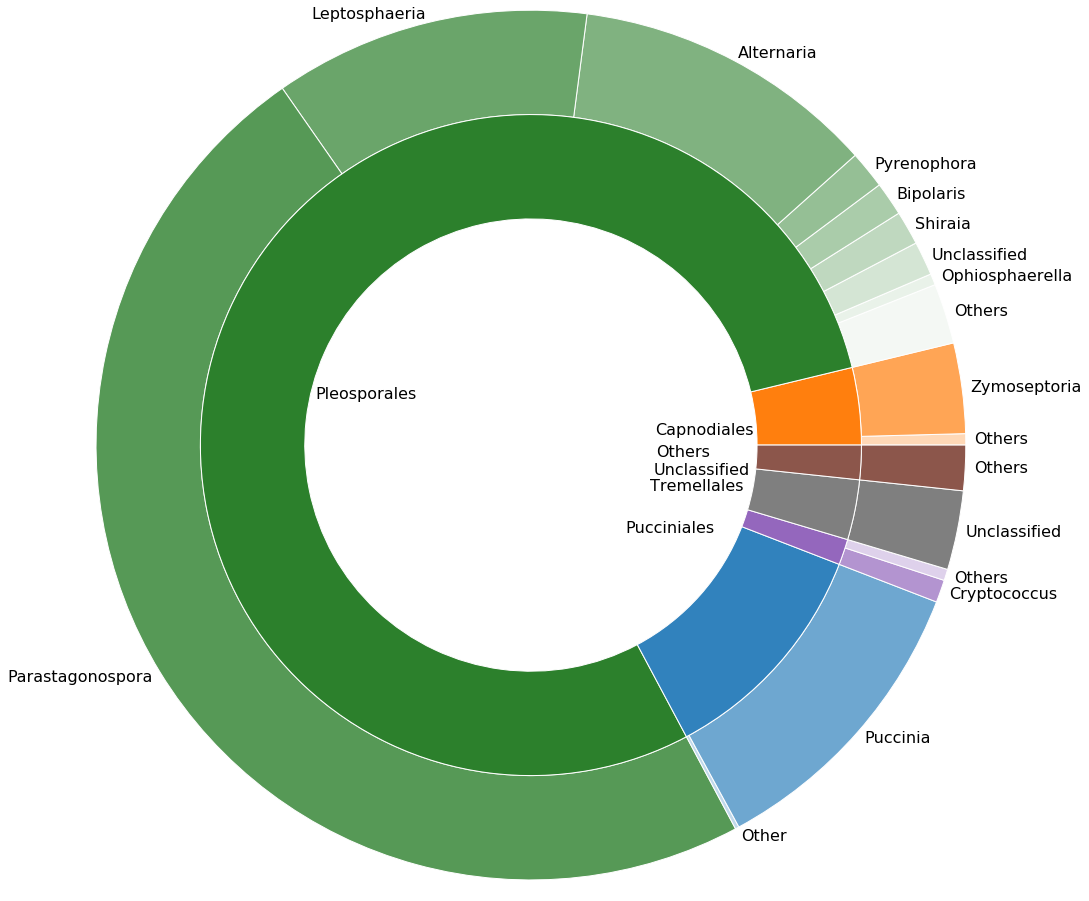

In [55]:
fig, ax = plt.subplots()
def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

cmap = matplotlib.cm.get_cmap('tab10')

width = 1.2

labels = modified_stago_pivot_df['genus']
pie, _ = ax.pie(modified_stago_pivot_df['phylum'], 
                radius=5,labels=labels, 
                labeldistance=1.02,
                textprops={'fontsize': 16},
                colors=color_list)
plt.setp( pie, width=width, edgecolor='white')


pie2, _ = ax.pie(order_df['number'], 
                 radius=5-width, 
                 labels=order_df['order'],
                 labeldistance=0.38, 
                 textprops={'fontsize': 16},
                 colors=[(1.0, 0.49803921568627452, 0.054901960784313725, 1.0),
                         (0.17254901960784313, 0.5, 0.17254901960784313, 1.0),
                         (0.19215686,  0.50980392,  0.74117647,  1.0),
                         (0.58039215686274515, 0.40392156862745099, 0.74117647058823533, 1.0),
                         (0.49803921568627452, 0.49803921568627452, 0.49803921568627452, 1.0),
                         (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)])
plt.setp( pie2, width=width, edgecolor='white')
ax.set(aspect="equal")

plt.savefig('/home/yiheng/analysis/WGS/figures/' + 'supplimentary_stago.png', bbox_inches='tight', dpi = 600)
plt.show()

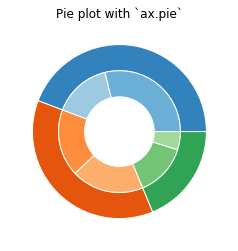

In [23]:
# example that I follow
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()